In [ ]:
'''
(4) It classifies building types 
from OSM building data into three categories (# 0 : NA ; 1 : residential or mixed-use ; 2 : non-residential) based on their attributes and spatial 
relationships with non-populated land use areas, adjusting the classification with additional criteria, and finally saves the updated classification
data in a column named 'type'.

'''

In [13]:
# 0.1 : libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [16]:
# 0.2 : Box to fil with informations

# Name of the case study
Name = 'Nice'

# Recall the ghs date (extracted in previous step)
ghs_date = 2020

# Define projected CRS
projected_crs = 'EPSG:2154'

In [17]:
gpkg = f'PPCA1_{Name}.gpkg'
gpkg2 = f'PPCA2_{Name}.gpkg'

Percentage and count of building types using attribute values, specialized columns & landuse
0 : NA: 74.33% (17768 buildings)
1 : Residential or mixed-use: 20.59% (4921 buildings)
2 : Non-residential: 5.09% (1216 buildings)


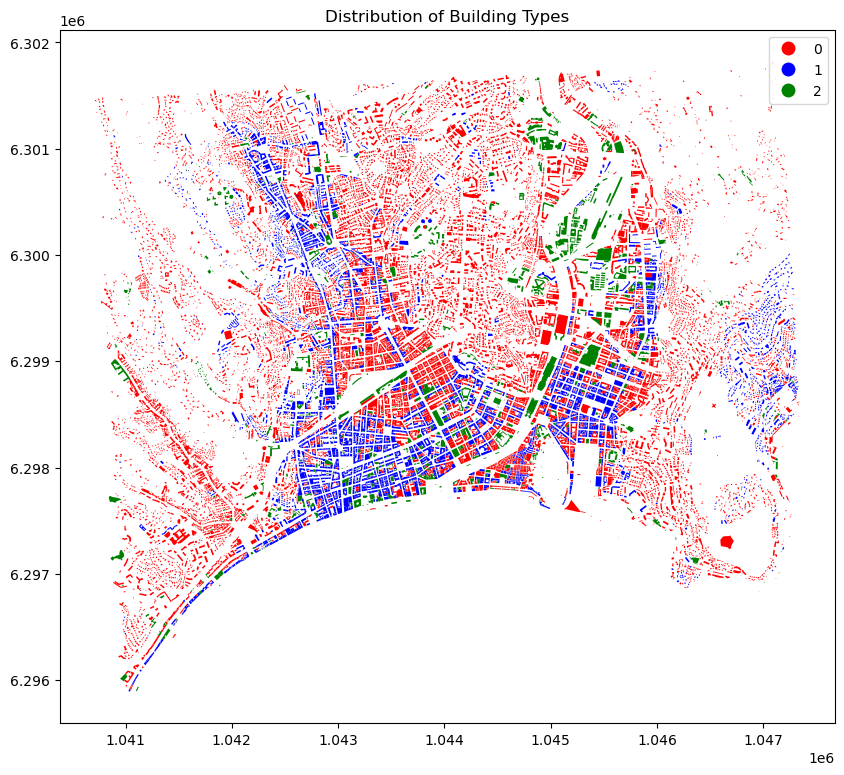

In [18]:
# 4. CLASIFICATION OF BUILDING TYPES
# Read all buildings from PPCA 1.0
all_building = gpd.read_file(gpkg, layer = 'osm_all_buildings')
non_populated_areas = gpd.read_file(gpkg2, layer = 'osm_non_populated_areas')

# Calculate the footprint of each building
all_building = all_building.to_crs(projected_crs)
all_building['area'] = all_building.geometry.area

# Filter out buildings with a surface footprint less than 15 m²
building_filtered = all_building[all_building['area'] >= 15]

# Filter out buildings with no walls (if the wall column exists)
if 'wall' in building_filtered.columns:
    building_filtered = building_filtered[building_filtered['wall'] != 'no']

# Define a function to determine the type based on the 'building' column (0 : NA ; 1 : residential or mixed-use ; 2 : non-residential)
# Attribute values : https://wiki.openstreetmap.org/wiki/Key:building
def assign_type(building_type):
    if building_type == 'yes':
        return 0
    elif building_type in ['apartments', 'barracks', 'house', 'residential', 'bungalow', 'cabin', 'detached', 'dormitory', 'farm', 'static_caravan',
                          'semidetached_house', 'stilt_house']:
        return 1
    else:
        return 2

# Add a new column 'type' and apply the conditions
building_filtered = building_filtered.copy()
building_filtered.loc[:, 'type'] = building_filtered['building'].apply(assign_type)

# Spatial join with non-residential landuse areas
non_populated_areas = non_populated_areas.to_crs(projected_crs)
joined_data = gpd.sjoin(building_filtered, non_populated_areas, how="left", predicate="intersects")

# Buildings with NA in non-residential landuse areas are given the value 2 (non residential)
joined_data.loc[(joined_data['type'] == 0) & joined_data['landuse'].notnull(), 'type'] = 2

# Update 'type' to 2 if 'type' is 0 (NA) and at least one non-null value exists in the following columns : 'tourism', 'parking', 'shop' or 'office'
condition = (joined_data['type'] == 0) & \
            (joined_data['tourism'].notnull() | \
             joined_data['parking'].notnull() | \
             joined_data['shop'].notnull() | \
             joined_data['office'].notnull())
joined_data.loc[condition, 'type'] = 2

# Print the percentage and count of each building type
feature_counts = joined_data['type'].value_counts()
type_counts = joined_data['type'].value_counts(normalize=True) * 100
print("Percentage and count of building types using attribute values, specialized columns & landuse")
for type_code, percentage in type_counts.items():
    feature_count = feature_counts[type_code]
    if type_code == 0:
        print(f"0 : NA: {percentage:.2f}% ({feature_count} buildings)")
    elif type_code == 1:
        print(f"1 : Residential or mixed-use: {percentage:.2f}% ({feature_count} buildings)")
    else:
        print(f"2 : Non-residential: {percentage:.2f}% ({feature_count} buildings)")

columns_to_drop = ['index_right', 'element_type_right', 'osmid_right', 'landuse']
joined_data = joined_data.drop(columns=columns_to_drop)

# Plot with custom colors
colors = ['red', 'blue', 'green']
fig, ax = plt.subplots(figsize=(10, 10))
joined_data.plot(column='type', categorical=True, legend=True, ax=ax, cmap=ListedColormap(colors))
plt.title('Distribution of Building Types')
plt.show()

#joined_data.to_file(gpkg2, layer='osm_buildings_use_with_NA', driver="GPKG")